In [208]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from pandas.plotting import lag_plot,autocorrelation_plot
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
import folium
from folium.plugins import MarkerCluster
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,LSTM,Bidirectional

sns.set_style("darkgrid")
os.chdir("/home/sadil/Data Science Projects/COVID-19")

In [209]:
conf_link="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
death_link="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
reco_link="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"

In [210]:
confirmed=pd.read_csv(conf_link,parse_dates=[0])
death=pd.read_csv(death_link,parse_dates=[0])
recovered=pd.read_csv(reco_link,parse_dates=[0])

In [211]:
confirmed.columns=['State','Country','Lat','Long']+list(confirmed.columns)[4:]
death.columns=['State','Country','Lat','Long']+list(death.columns)[4:]
recovered.columns=['State','Country','Lat','Long']+list(recovered.columns)[4:]

In [5]:
def multi(dataset,time):
    multiplier1=dataset[dataset>5].values[1:time]
    multiplier2=dataset[dataset>5].values[:time-1]

    mul=multiplier1/multiplier2
    
    return mul

In [116]:
china_confirmed=confirmed[confirmed['Country']=='China'].iloc[:,4:].sum(axis=0)
china_recovered=recovered[recovered['Country']=='China'].iloc[:,4:].sum(axis=0)


usa_confirmed=confirmed[confirmed['Country']=='US'].iloc[:,4:].sum(axis=0)
usa_recovered=recovered[recovered['Country']=='US'].iloc[:,4:].sum(axis=0)

# Folium Map

In [288]:
country=confirmed['Country'].unique()
state=confirmed[confirmed['Country']=='China']['State'].values

In [293]:
pos=confirmed[confirmed['Country']==country[0]][['Lat','Long']].values[-1]
my_map=folium.Map(location=pos)

con=confirmed[confirmed['Country']==country[0]].iloc[:,4:].sum(axis=0).values[-1]
rec=recovered[recovered['Country']==country[0]].iloc[:,4:].sum(axis=0).values[-1]
de=death[death['Country']==country[0]].iloc[:,4:].sum(axis=0).values[-1]


folium.Marker(pos,icon=folium.Icon(color='blue'),
                popup = f'{country[0]}\n Confirmed:{con}\n Recovered:{rec}\n Death:{de}').add_to(my_map)

    


for i in range(1,len(country)):
    if country[i]!='China':
        pos=confirmed[confirmed['Country']==country[i]][['Lat','Long']].values[-1]
        folium.Map(location=pos).add_to(my_map)
        con=confirmed[confirmed['Country']==country[i]].iloc[:,4:].sum(axis=0).values[-1]
        rec=recovered[recovered['Country']==country[i]].iloc[:,4:].sum(axis=0).values[-1]
        de=death[death['Country']==country[i]].iloc[:,4:].sum(axis=0).values[-1]

        if con>10000:
            folium.Marker(pos,icon=folium.Icon(color='red'),
                          popup = f'{country[i]}\n Confirmed:{con}\n Recovered:{rec}\n Death:{de}').add_to(my_map)
        elif con>1000:
            folium.Marker(pos,icon=folium.Icon(color='orange'),
                          popup = f'{country[i]}\n Confirmed:{con}\n Recovered:{rec}\n Death:{de}').add_to(my_map)
        else:
            folium.Marker(pos,icon=folium.Icon(color='blue'),
                          popup = f'{country[i]}\n Confirmed:{con}\n Recovered:{rec}\n Death:{de}').add_to(my_map)
    else:
        for j in range(len(state)):
            pos=confirmed[confirmed['State']==state[j]][['Lat','Long']].values[-1]
            folium.Map(location=pos).add_to(my_map)
            con=confirmed[confirmed['State']==state[j]].iloc[:,4:].sum(axis=0).values[-1]
            rec=recovered[recovered['State']==state[j]].iloc[:,4:].sum(axis=0).values[-1]
            de=death[death['State']==state[j]].iloc[:,4:].sum(axis=0).values[-1]

            if con>10000:
                folium.Marker(pos,icon=folium.Icon(color='red'),
                              popup = f'Province:{state[j]} (China)\n Confirmed:{con}\n Recovered:{rec}\n Death:{de}').add_to(my_map)
            elif con>1000:
                folium.Marker(pos,icon=folium.Icon(color='orange'),
                              popup = f'Province:{state[j]} (China)\n Confirmed:{con}\n Recovered:{rec}\n Death:{de}').add_to(my_map)
            else:
                folium.Marker(pos,icon=folium.Icon(color='blue'),
                              popup = f'Province:{state[j]} (China)\n Confirmed:{con}\n Recovered:{rec}\n Death:{de}').add_to(my_map)
    


In [294]:
my_map

In [295]:
my_map.save('corona_country.html')

# Cases of Italy

In [7]:
italy_confirmed=confirmed[confirmed['Country']=='Italy'].iloc[:,4:].sum(axis=0)
italy_recovered=recovered[recovered['Country']=='Italy'].iloc[:,4:].sum(axis=0)

Text(0.5, 1.0, 'China vs Italy Confirmed Cases')

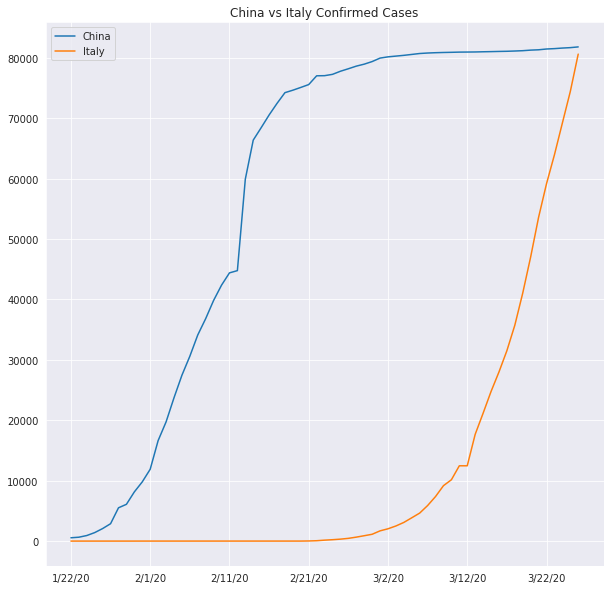

In [296]:
plt.figure(figsize=(10,10))
china_confirmed.plot()
italy_confirmed.plot()
plt.legend(['China','Italy'])
plt.title("China vs Italy Confirmed Cases")

(0, 90000)

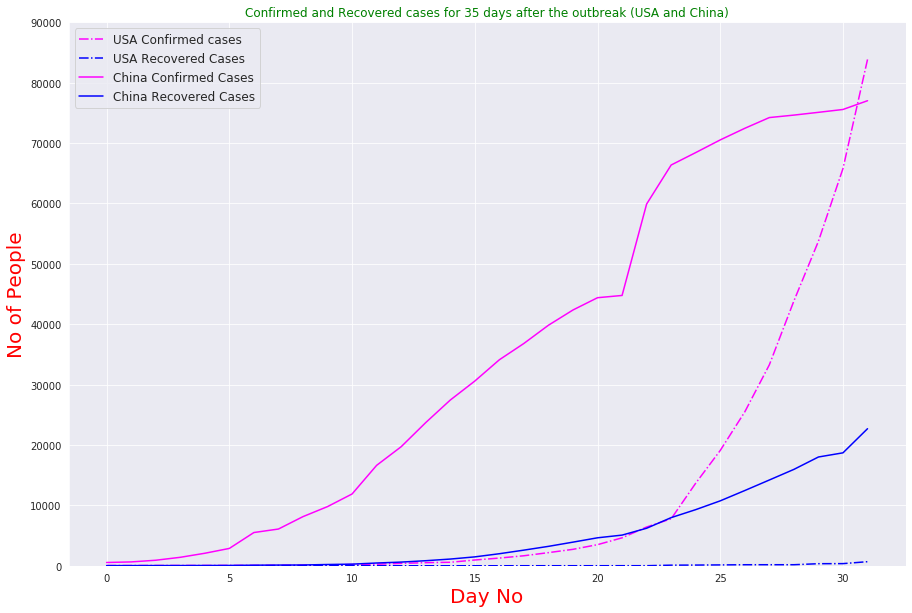

In [130]:
plt.figure(figsize=(15,10))
# Plot
plt.plot(list(range(32)),usa_confirmed.iloc[33:],color='magenta',linestyle='-.')
plt.plot(list(range(32)),usa_recovered.iloc[33:],color='blue',linestyle='-.')
plt.plot(list(range(32)),china_confirmed.iloc[:32],color='magenta')
plt.plot(list(range(32)),china_recovered.iloc[:32],color='blue')


plt.xlabel("Day No",color='red',fontsize=20)
plt.ylabel("No of People",color='red',fontsize=20)
           
plt.legend(['USA Confirmed cases','USA Recovered Cases',
           "China Confirmed Cases",'China Recovered Cases'],fontsize='large')
plt.title("Confirmed and Recovered cases for 35 days after the outbreak (USA and China)",color='green')
plt.ylim(0,90000)

(0, 90000)

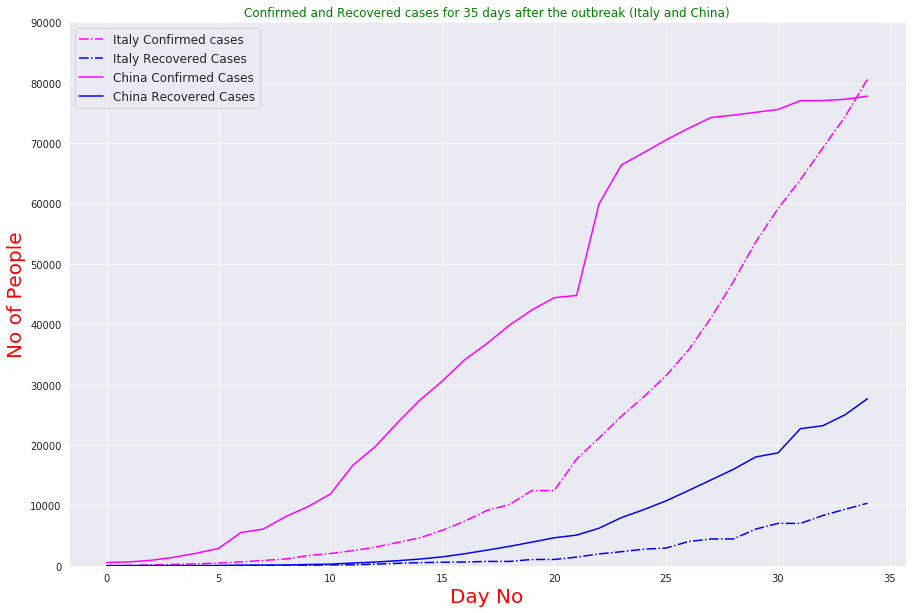

In [64]:
plt.figure(figsize=(15,10))
y=italy_recovered.iloc[30:]

# Plot
plt.plot(list(range(35)),italy_confirmed.iloc[30:],color='magenta',linestyle='-.')
plt.plot(list(range(35)),italy_recovered.iloc[30:],color='blue',linestyle='-.')
plt.plot(list(range(35)),china_confirmed.iloc[:35],color='magenta')
plt.plot(list(range(35)),china_recovered.iloc[:35],color='blue')


plt.xlabel("Day No",color='red',fontsize=20)
plt.ylabel("No of People",color='red',fontsize=20)
           
plt.legend(['Italy Confirmed cases','Italy Recovered Cases',
           "China Confirmed Cases",'China Recovered Cases'],fontsize='large')
plt.title("Confirmed and Recovered cases for 35 days after the outbreak (Italy and China)",color='green')
plt.ylim(0,90000)

Text(0.5, 1.0, 'Italy Confirmed Cases')

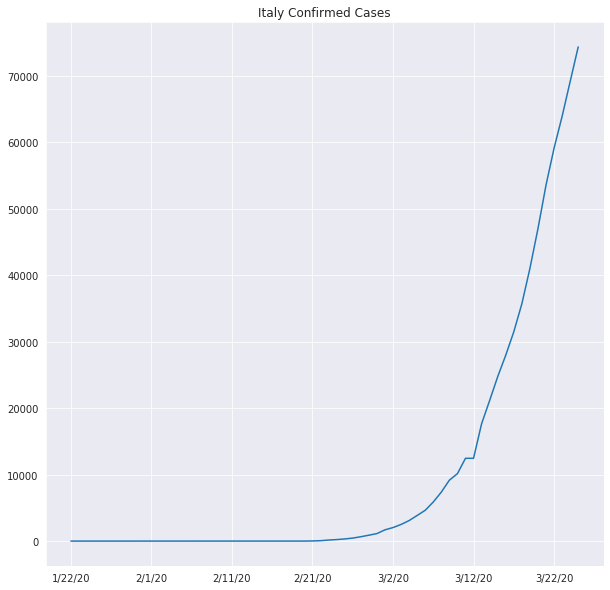

In [10]:
plt.figure(figsize=(10,10))
italy_confirmed.plot()
plt.title('Italy Confirmed Cases')

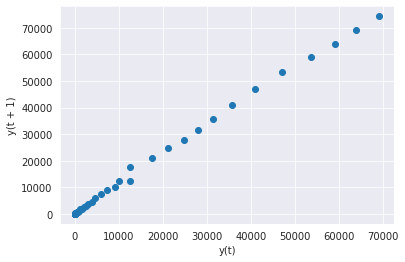

In [11]:
lag_plot(italy_confirmed)

# Cases of India

In [65]:
india_confirmed=confirmed[confirmed['Country']=='India'].iloc[:,4:].sum(axis=0)

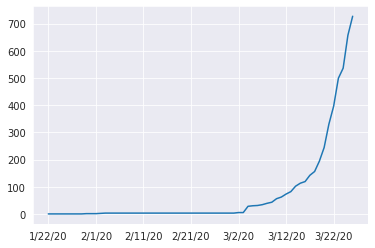

In [66]:
india_confirmed.plot()

In [67]:
m1=multi(china_confirmed,20)
m2=multi(india_confirmed,20)

Text(0.5, 1.0, 'The times cases increase from previous date')

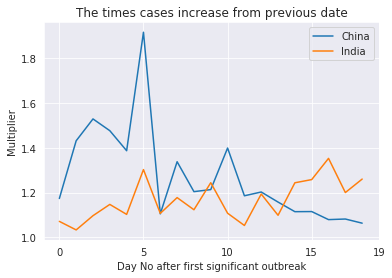

In [68]:
sns.lineplot(list(range(19)),m1)
sns.lineplot(list(range(19)),m2)
plt.xticks([0,5,10,15,19])
plt.xlabel('Day No after first significant outbreak')
plt.ylabel('Multiplier')
plt.legend(["China",'India'])
plt.title('The times cases increase from previous date')

Text(0.5, 1.0, 'Autocorrelation Plot')

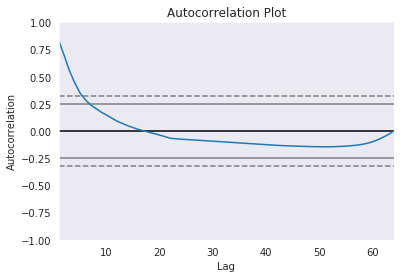

In [16]:
autocorrelation_plot(india_confirmed)
plt.title('Autocorrelation Plot')

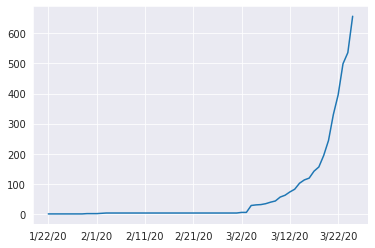

In [17]:
india_confirmed.plot()

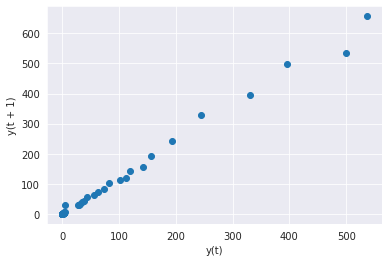

In [18]:
lag_plot(india_confirmed)

# Autoregression

In [19]:
def model_ar(dataset,t_s1,t_s2):
    model=AR(dataset[:t_s1])
    model=model.fit()
    
    predict=model.predict(t_s1,t_s2)
    
    #Plotting
    plt.plot(predict.values)
    plt.plot(dataset[t_s1:].values)
    plt.legend(['Predicted','Actual'])
    
    
    # Evaluation
    print(f'RMSE Score:{np.sqrt(mean_squared_error(dataset[t_s1:],predict))}')

RMSE Score:30577.414918747745


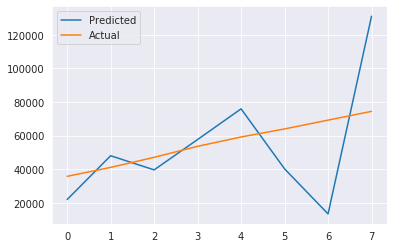

In [18]:
model_ar(italy_confirmed,56,len(india_confirmed)-1)

# Moving Average

In [19]:
def model_ma(dataset,t_s1,t_s2):
    model=ARMA(dataset[:t_s1],order=(0,1)).fit(disp=False)
    
    predict=model.predict(t_s1,t_s2)
    
    #Plotting
    plt.plot(predict.values)
    plt.plot(dataset[t_s1:].values)
    plt.legend(['Predicted','Actual'])
    
    # Evaluation
    print(f'RMSE Score:{np.sqrt(mean_squared_error(dataset[t_s1:],predict))}')

RMSE Score:391.7050817946429


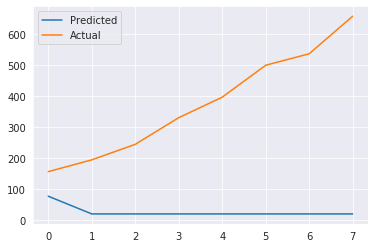

In [20]:
model_ma(india_confirmed,56,len(india_confirmed)-1)

# LSTM model

In [106]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X,dtype=np.float32), np.array(y,dtype=np.float32)
n_steps=1
x,y=split_sequence(india_confirmed.values,n_steps)

In [107]:
x_train=x.copy()
x_train.resize((x_train.shape[0],x_train.shape[1],1))
"""x_test=x[6:].copy()
x_test.resize((x_test.shape[0],x_test.shape[1],1))"""
y_train=y
#y_test=y[6:]

In [108]:
def model_lstm(x_train,y_train):
    model = Sequential()
    model.add(LSTM(32, activation='relu',return_sequences=True, input_shape=(n_steps,1)))
    model.add(LSTM(64,activation='relu',return_sequences=True))
    model.add(LSTM(128,activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    
    model.fit(x_train,y_train,epochs=300,verbose=0)
    
    predict=model.predict(x_train)
    
    #Plotting
    forecast=[]
    temp=predict[-1].reshape(1,1,1)
    for i in range(27,54):
        temp_pred=model.predict(temp)
        if i>31:
            print((f'{i%31}-4-20',temp_pred[0][0]))
        else:
            print((f'{i}-3-20',temp_pred[0][0]))
        forecast.append(temp_pred[0][0])
        temp=temp_pred.reshape(1,1,1)
    
    plt.plot(predict)
    plt.plot(x_train.reshape(-1))
    plt.legend(['Predicted'],['Actual'])
    
    
    # Evaluation
    print(f'RMSE Score:{np.sqrt(mean_squared_error(y_train,predict))}')

('27-3-20', 823.63635)
('28-3-20', 916.04346)
('29-3-20', 1016.4962)
('30-3-20', 1126.2474)
('31-3-20', 1246.5319)
('1-4-20', 1378.6334)
('2-4-20', 1523.9238)
('3-4-20', 1683.8857)
('4-4-20', 1860.1296)
('5-4-20', 2054.4094)
('6-4-20', 2268.6396)
('7-4-20', 2504.9158)
('8-4-20', 2765.536)
('9-4-20', 3053.0251)
('10-4-20', 3370.1628)
('11-4-20', 3720.0115)
('12-4-20', 4105.9463)
('13-4-20', 4531.6914)
('14-4-20', 5001.353)
('15-4-20', 5519.4614)
('16-4-20', 6091.013)
('17-4-20', 6721.522)
('18-4-20', 7417.07)
('19-4-20', 8184.365)
('20-4-20', 9030.809)
('21-4-20', 9964.564)
('22-4-20', 10994.64)
RMSE Score:9.284370422363281


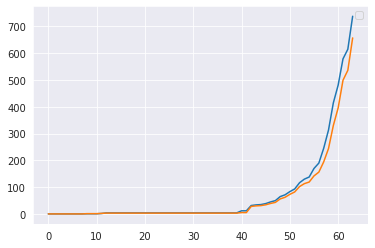

In [109]:
model_lstm(x_train,y_train)

In [110]:
def model_bilstm(x_train,y_train):
    model = Sequential()
    model.add(Bidirectional(LSTM(64, activation='relu',return_sequences=True), input_shape=(n_steps, 1)))
    model.add(Bidirectional(LSTM(128, activation='relu',return_sequences=True)))
    model.add(Bidirectional(LSTM(256, activation='relu')))    
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    model.fit(x_train,y_train,epochs=300,verbose=0)
    predict=model.predict(x_train)
    
    #Plotting
    """plt.plot(predict)
    plt.plot(y_test)
    plt.legend(['Predicted','Actual'])"""
    
    forecast=[]
    temp=predict[-1].reshape(1,1,1)
    for i in range(27,55):
        temp_pred=model.predict(temp)
        if i>31:
            print((f'{i%31}-4-20',temp_pred[0][0]))
        else:
            print((f'{i}-3-20',temp_pred[0][0]))
        forecast.append(temp_pred[0][0])
        temp=temp_pred.reshape(1,1,1)
    plt.plot(predict)
    plt.plot(x_train.reshape(-1))
    plt.legend(['Predicted'],['Actual'])

    
    # Evaluation
    #print(f'RMSE Score:{np.sqrt(mean_squared_error(y_test,predict))}')

('27-3-20', 841.28174)
('28-3-20', 942.5068)
('29-3-20', 1052.6011)
('30-3-20', 1173.4344)
('31-3-20', 1306.7944)
('1-4-20', 1454.4585)
('2-4-20', 1618.2535)
('3-4-20', 1800.1093)
('4-4-20', 2002.108)
('5-4-20', 2226.5264)
('6-4-20', 2475.8752)
('7-4-20', 2752.9353)
('8-4-20', 3060.7908)
('9-4-20', 3402.868)
('10-4-20', 3782.9714)
('11-4-20', 4205.329)
('12-4-20', 4674.6387)
('13-4-20', 5196.12)
('14-4-20', 5775.572)
('15-4-20', 6419.4404)
('16-4-20', 7134.8853)
('17-4-20', 7929.863)
('18-4-20', 8813.215)
('19-4-20', 9794.768)
('20-4-20', 10885.437)
('21-4-20', 12097.351)
('22-4-20', 13443.992)
('23-4-20', 14940.335)


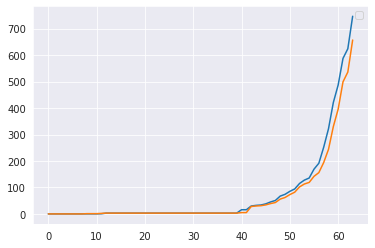

In [111]:
model_bilstm(x_train,y_train)